In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import dask
import dask.dataframe as dd

In [ ]:
path ='/kaggle/input/ashrae-energy-prediction/'
building_meta=dd.read_csv(f'{path}building_metadata.csv')
weather_tr=dd.read_csv(f'{path}weather_train.csv')                         
test=dd.read_csv(f'{path}test.csv')
train=dd.read_csv(f'{path}train.csv')
weather_tst=dd.read_csv(f'{path}weather_test.csv')

In [ ]:
train.head()

In [ ]:
# del building_meta, weather_tr, train, test, weather_tst

In [ ]:
train.head()

In [ ]:
print(building_meta.head())
print(building_meta.shape)
print(train.shape)
print(test.shape)

In [ ]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
# train=reduce_mem_usage(train,use_float16=True)
# weather_tr=reduce_mem_usage(weather_tr,use_float16=True)
# building_meta=reduce_mem_usage(building_meta,use_float16=True)

In [ ]:
# sample_train_nj = train.sample(frac=.1) # sample nj: not joined
# sample_train_nj.shape

In [ ]:
# sample_train_nj.head()

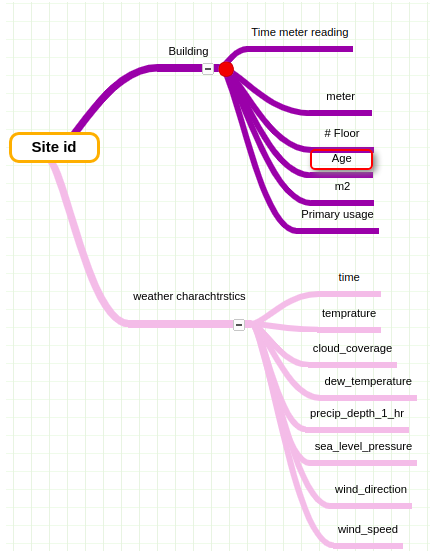

In [ ]:
train_merge = train.merge(building_meta , on='building_id' , how ='left')
train_merge = train_merge.merge(weather_tr, on=['site_id', 'timestamp'], how='left')
train_merge.head()

In [ ]:
# most building in the sample has null values in floor count and year built so we can remove them 
print('features with null values:\n' ,train_merge.isnull().sum() *100 /train_merge.shape[0])

In [ ]:
## note: every building may have multiple meters(0: electricity, 1: chilledwater, 2: steam, 3: hotwater) 


## Anova

H0: feature and target are uncorrelated

H1: feature and target are correlated
f_classif result is [f_value, p_value]. p_value<0.05 rejects the null hypothesis(H0) and means that feature and target are correlated

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
train_merge['primary_use'] = le.fit_transform(train_merge['primary_use'])
train_merged_anova = train_merge.sample(frac = 0.1)
print(le.classes_)
train_merged_anova.head()

In [ ]:
train_merged_anova_nona = train_merged_anova.dropna()
train_merged_anova_nona.head()

In [ ]:
train_merged_anova_nona.min()

In [ ]:
train_merged_anova_nona.dew_temperature += 9.4
train_merged_anova_nona.precip_depth_1_hr += 1

In [ ]:
f_classif(train_merged_anova_nona.meter.values.reshape((-1,1)), train_merged_anova_nona.meter_reading.values.reshape((-1)))

In [ ]:
f_classif(train_merged_anova_nona.primary_use.values.reshape((-1,1)), train_merged_anova_nona.meter_reading.values.reshape((-1)))

In [ ]:
f_classif(train_merged_anova_nona.floor_count.values.reshape((-1,1)), train_merged_anova_nona.meter_reading.values.reshape((-1)))

In [ ]:
train_merge['timestamp'] = dd.to_datetime(train_merge['timestamp'] )

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train_merge[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train_merge[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

In [ ]:
train_merge.groupby('meter').meter_reading.agg(['mean', 'std', 'median'])

In [ ]:
weather_tr.dropna().groupby('site_id').mean()

In [ ]:
columns = weather_tr.drop(['timestamp', 'site_id'], axis =1).columns
weather_tr_scaled = weather_tr.copy()
weather_tr_scaled[columns] = MinMaxScaler().fit_transform(weather_tr_scaled[columns])

In [ ]:
weather_tr_scaled.groupby('site_id').boxplot(column=list(columns),
                                             layout=(-1,1), sharex=False,
                                             fontsize=13, figsize=(15,50))
plt.tight_layout()

In [ ]:

corr = train_merge.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot = True)

In [ ]:
train_merge_reduce=reduce_mem_usage(train_merge,use_float16=True)

In [ ]:
columns = train_merge.drop(['building_id', 'timestamp','site_id',], axis=1).columns
columns = list(columns)
columns

In [ ]:
round(len(columns)/2)

## relation of different parameters on meter reading

In [ ]:
del train_merge, train

In [ ]:
train_merge_reduce.head()

In [ ]:

plt.figure(figsize=(15, 20))
for i, column in enumerate(columns):
    ax = plt.subplot(round(len(columns)/2) +1, 2, i+1)
    train_merge.plot(ax=ax, kind = 'scatter', x = column, y = 'meter_reading')
    
plt.tight_layout()

## Feature engineering
* mean & std, Min & Max of air_temperature of sites


In [ ]:
train_merge.groupby('building_id').air_temperature.agg(['mean', 'std', 'min', 'max']).compute()

In [ ]:
train_merge_reduce.head()

In [ ]:
train_merge['month'] = train_merge.timestamp.map(lambda x:x.month)
train_merge['day'] = train_merge.timestamp.map(lambda x:x.day)
train_merge['hour'] = train_merge.timestamp.map(lambda x:x.hour)

In [ ]:
train_merge_reduce.tail()

In [ ]:
train_merge.groupby(['month','day']).air_temperature.agg(['mean', 'std', 'min', 'max']).compute()

In [ ]:
del train, train_merge

## Creating a Baseline.
Baseline: mean of meter_reading in previus years

In [ ]:
test.head()

In [ ]:
test_merge = test.merge(building_meta , on='building_id' , how ='left')
test_merge = test_merge.merge(weather_tst, on=['site_id', 'timestamp'], how='left')
test_merge.head()

In [ ]:
test_merge = reduce_mem_usage(test_merge)

In [ ]:
import gc


In [ ]:
gc.collect()

In [ ]:
del weather_tr, weather_tst,test

In [ ]:
test_merge['timestamp'] = dd.to_datetime(test_merge['timestamp'] )

In [ ]:
test_merge['month'] = test_merge.timestamp.map(lambda x:x.month)
test_merge['day'] = test_merge.timestamp.map(lambda x:x.day)
test_merge['hour'] = test_merge.timestamp.map(lambda x:x.hour)

In [ ]:
train_merge_reduce.head()

In [ ]:
train_merge_reduce.head()

In [ ]:
def baseline_predict(sample):
    #find the mean of rows in train data where month&day&hour is same as given sample
    return train_merge[(train_merge.building_id==sample.building_id) & (train_merge.month==sample.month) & (train_merge.day==sample.day) & (train_merge.hour==sample.hour)].meter_reading.mean()

In [ ]:
test_merge['pred_meter_reading'] = test_merge.apply(baseline_predict, axis = 1)

In [ ]:
baseline_predict(test_merge.iloc[4000,:])

In [ ]:
train_merge.loc[0, :].compute()